In [1]:
##Importing the modules##

import numpy as np
import xarray as xr
import math as mt
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
import glob
import cartopy.crs as ccrs
from matplotlib.patches import Rectangle
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from metpy.plots import USCOUNTIES
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import metpy.calc as mpcalc
from metpy.units import units
from scipy import stats
from collections import Counter
import cftime

print("Done importing modules")

Done importing modules


In [15]:
##Import the dataset and the binary T52 mask##

CF_df_All = xr.open_dataset('/projects/zami4053/Synoptic_Research/Netcdf_CF/CF_xr_723.nc')
#CF_df

binmask = xr.open_dataset('/projects/zami4053/Synoptic_Research/Netcdf_CF/binary_mask_T52.nc')
#binmask

CF_df_LP = xr.open_dataset('/projects/zami4053/Synoptic_Research/Netcdf_CF/CF_xr_LP145.nc')
#CF_df_LP

CF_df_HP = xr.open_dataset('/projects/zami4053/Synoptic_Research/Netcdf_CF/CF_xr_HP145.nc')
#CF_df_HP

#Select a datset to use#
CF_df = CF_df_All.copy()   #can change this

In [16]:
# ###Now extract the LP and HP xr dataframes###

# #Combine dates from LP and HP sets#
# dates_LP = pd.to_datetime(CF_LP['date'])
# dates_HP = pd.to_datetime(CF_HP['date'])

# #Make sure the time values are in datetime#
# CF_df['time'] = pd.to_datetime(CF_df['time'].values)

# #Select the subset of xarray dataset based on the matching dates#
# CF_df_LP = CF_df.sel(time=CF_df['time'].isin(dates_LP))
# CF_df_HP = CF_df.sel(time=CF_df['time'].isin(dates_HP))

# #Save them to netcdfs#
# CF_df_LP.to_netcdf('CF_xr_LP145.nc')
# CF_df_HP.to_netcdf('CF_xr_HP145.nc')

In [17]:
###Elevation data###

#ERA5 terrain stuff with geopotential#
input_elv = 'Other_Data/terrain_0.1.nc'
df_elevation = xr.open_dataset(input_elv)
#df_elevation['z'].plot()

#Define bounds for all of Colorado#
lon_min = 251  
lon_max = 258   
lat_min = 37
lat_max = 41

#Define bounds for all of USo#
lon_min_US = 235  
lon_max_US = 293   
lat_min_US = 23
lat_max_US = 50

#Slice out the array and convert to height [m]# 
df_ele_CO = df_elevation.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_max, lat_min))
df_ele_US = df_elevation.sel(longitude=slice(lon_min_US, lon_max_US), latitude=slice(lat_max_US, lat_min_US))
heights = (df_ele_CO['z'][0,:,:].values) / 9.81
heights_US = (df_ele_US['z'][0,:,:].values) / 9.81
heights_US.shape, heights.shape

((271, 581), (41, 71))

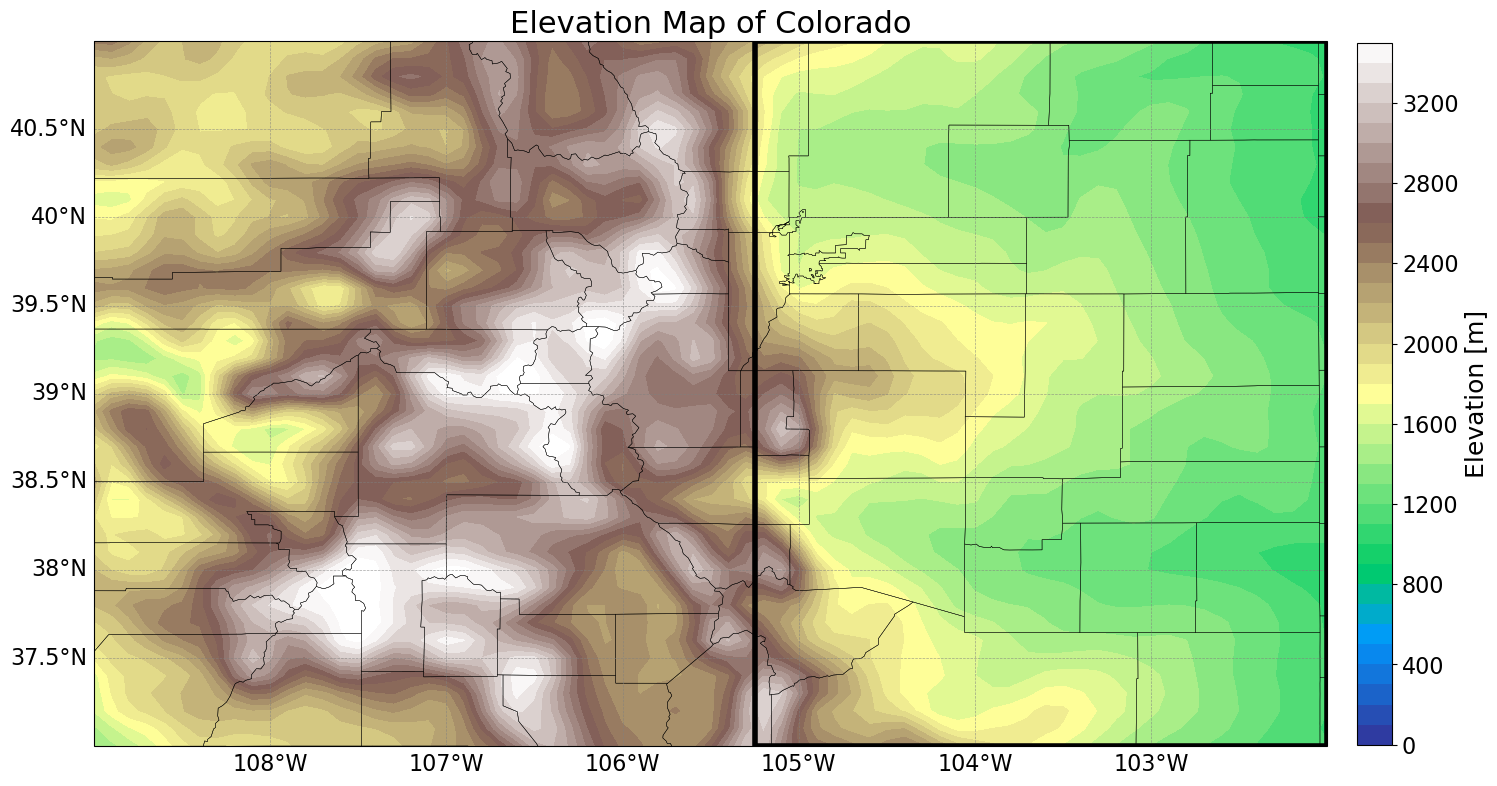

In [18]:
###Plot an elevation insert###

fig, ax = plt.subplots(figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})

#Define elevation levels#
clevels = np.arange(0, 3600, 100)

# Plot ocean mask: draw ocean in white
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='white', zorder=5)

#Plotting#
im = ax.contourf(df_ele_CO['longitude'], df_ele_CO['latitude'], heights,
                 levels=clevels, cmap='terrain', transform=ccrs.PlateCarree())
# im2 = ax.contourf(df_ele_US['longitude'], df_ele_US['latitude'], heights_US,
#                  levels=clevels, cmap='terrain', transform=ccrs.PlateCarree())

#Colorbar#
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02, aspect=20, shrink=0.6)
cbar.set_label('Elevation [m]', fontsize=18)
cbar.ax.tick_params(labelsize=16)

#Add county borders#
ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='black', linewidth=0.3)

#Set plot extent to Colorado area#
ax.set_extent([df_ele_CO['longitude'].min(), df_ele_CO['longitude'].max(),
               df_ele_CO['latitude'].min(), df_ele_CO['latitude'].max()],
              crs=ccrs.PlateCarree())

#Define the bounding box#
lon_min_box, lon_max_box = -105.25, -102.0
lat_min_box, lat_max_box = 37.0, 41.0

#Width and height of the box#
width = lon_max_box - lon_min_box
height = lat_max_box - lat_min_box

#Create and add the rectangle#
rect = Rectangle((lon_min_box, lat_min_box), width, height,
                 linewidth=4, edgecolor='black', facecolor='none',
                 transform=ccrs.PlateCarree(), zorder=10)

ax.add_patch(rect)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Add labels and title
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.title('Elevation Map of Colorado', fontsize=22)

plt.tight_layout()
#plt.savefig("CO_elevation.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()

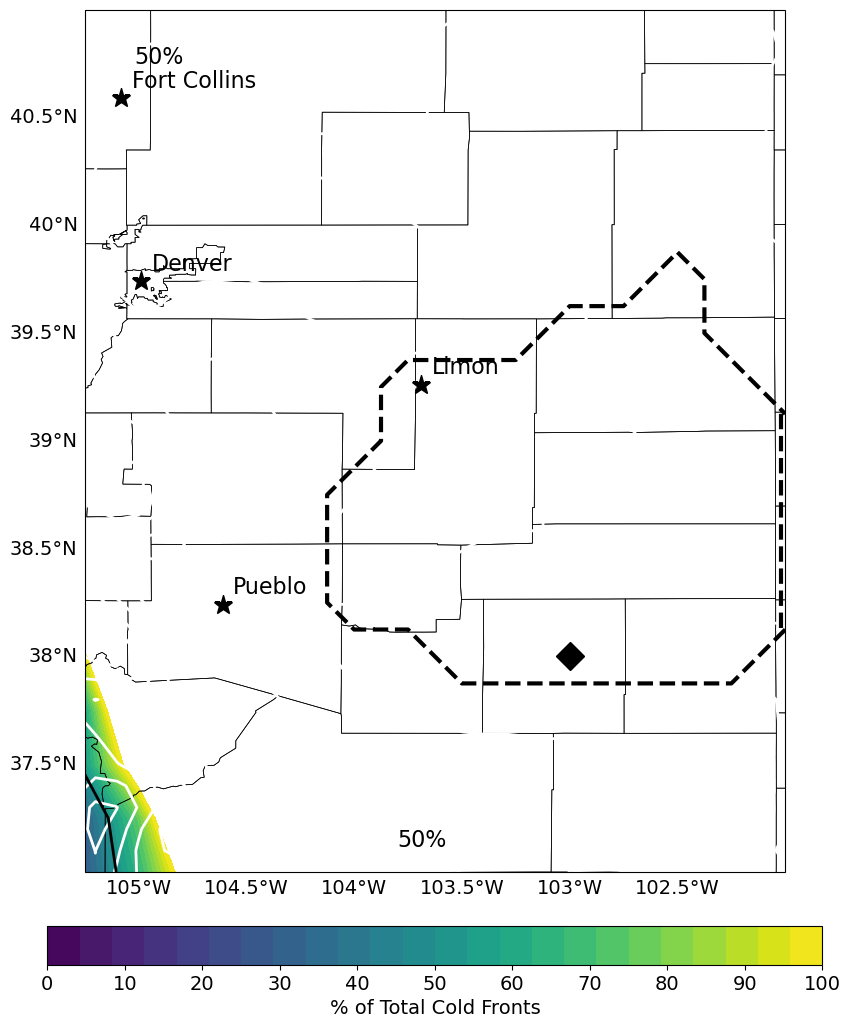

In [19]:
###Now redo the spatial heatmap for all 723 cases###

#Get the lons and lats#
lons = CF_df['longitude'].values
lats = CF_df['latitude'].values

#Get the frequency of flags for each grid cell#
CF_frequency = CF_df['CF_Dataset'].sum(dim='time')
CF_frequency_p = (CF_frequency / 145) * 100  #have to adjust total between 145 and 723

#Plot heatmap#
CF_levels_p = np.linspace(0, 100, num=25)

#Define the extent to tightly fit the data area#
lon_min, lon_max = np.min(lons), np.max(lons)
lat_min, lat_max = np.min(lats), np.max(lats)

#Make and configure the plot#
fig, ax = plt.subplots(1, figsize=(10, 14), subplot_kw={'projection': ccrs.PlateCarree()})
im1 = ax.contourf(lons, lats, CF_frequency_p, levels=CF_levels_p, cmap='viridis', transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(im1, ax=ax, orientation='horizontal', pad=0.05)
cbar1.set_ticks(np.linspace(0, 100, num=11))
cbar1.set_label(label='% of Total Cold Fronts', size=14)
cbar1.ax.tick_params(labelsize=14)

#Plot the elevation spatial data#
clevels = np.arange(800, 4000, 300)
im2 = ax.contour(df_ele_CO['longitude'], df_ele_CO['latitude'], heights, levels=clevels, colors='white', origin='lower', linewidths=2)

#Plot the T52 regions#
binmask_data = binmask['binary_mask_tcf'].values
im3 = ax.contour(lons, lats, binmask_data, levels=[0.5], colors='black', linestyles='dashed', linewidths=3, transform=ccrs.PlateCarree())
ax.plot(-103, 38, marker='D', markersize=14, color='black', transform=ccrs.PlateCarree()) 

#Add vertical line at the eastern edge of T52 region#
T52_east_edge = -102.02  # adjust if needed
ax.plot([T52_east_edge, T52_east_edge], [38.13, 39.14],
        color='black', linewidth=3, linestyle='dashed',
        transform=ccrs.PlateCarree(), zorder=5)

#Emphasize the 2 stdv contour T drop (-21)#
specific_level = [50]
ax.contour(lons, lats, CF_frequency_p, levels=specific_level, colors='black', linewidths=2, transform=ccrs.PlateCarree())
plt.text(-103.8, 37.12, '50%', color='black', fontsize=16, transform=ccrs.PlateCarree())
plt.text(-105.02, 40.75, '50%', color='black', fontsize=16, transform=ccrs.PlateCarree())
plt.tick_params(labelsize=16)
#plt.text(-102.6, 40.55, 'N=723', color='white', fontsize=16, transform=ccrs.PlateCarree())

#Plot some cities#
cities = {
    "Denver": (-104.99, 39.74),
    "Limon": (-103.69, 39.26),
    "Pueblo": (-104.61, 38.24),
    "Fort Collins": (-105.08, 40.59)
}

for city, (lon, lat) in cities.items():
    plt.plot(lon, lat, marker='*', markersize=14, markerfacecolor='black', markeredgecolor='black', transform=ccrs.PlateCarree())
    plt.text(lon + 0.05, lat + 0.05, city, color='black', fontsize=16, transform=ccrs.PlateCarree())

#Add county borders#
ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='black', linewidth=0.5)

#Set the extent to only show the area with data#
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

#Add gridlines and labels for latitude and longitude#
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='none')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}

#Configure plot#
#plt.title('Spatial Frequency Across all Cold Fronts', fontsize=18)
plt.savefig("CF_Frequency_LP_REV.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()

In [20]:
CF_df

<xarray.Dataset>
Dimensions:          (time: 723, latitude: 17, longitude: 14)
Coordinates:
  * longitude        (longitude) float32 -105.2 -105.0 -104.8 ... -102.2 -102.0
  * latitude         (latitude) float32 41.0 40.75 40.5 ... 37.5 37.25 37.0
  * time             (time) datetime64[ns] 1950-01-04 1950-01-30 ... 2022-12-23
Data variables:
    Daily_Max_Temps  (time, latitude, longitude) float32 ...
    Temp_Diffs       (time, latitude, longitude) float32 ...
    CF_Dataset       (time, latitude, longitude) float64 1.0 1.0 1.0 ... 1.0 1.0

In [28]:
np.nanmin(mean_strengths), np.nanmin(max_strengths)

(-46.84833, -61.884693)

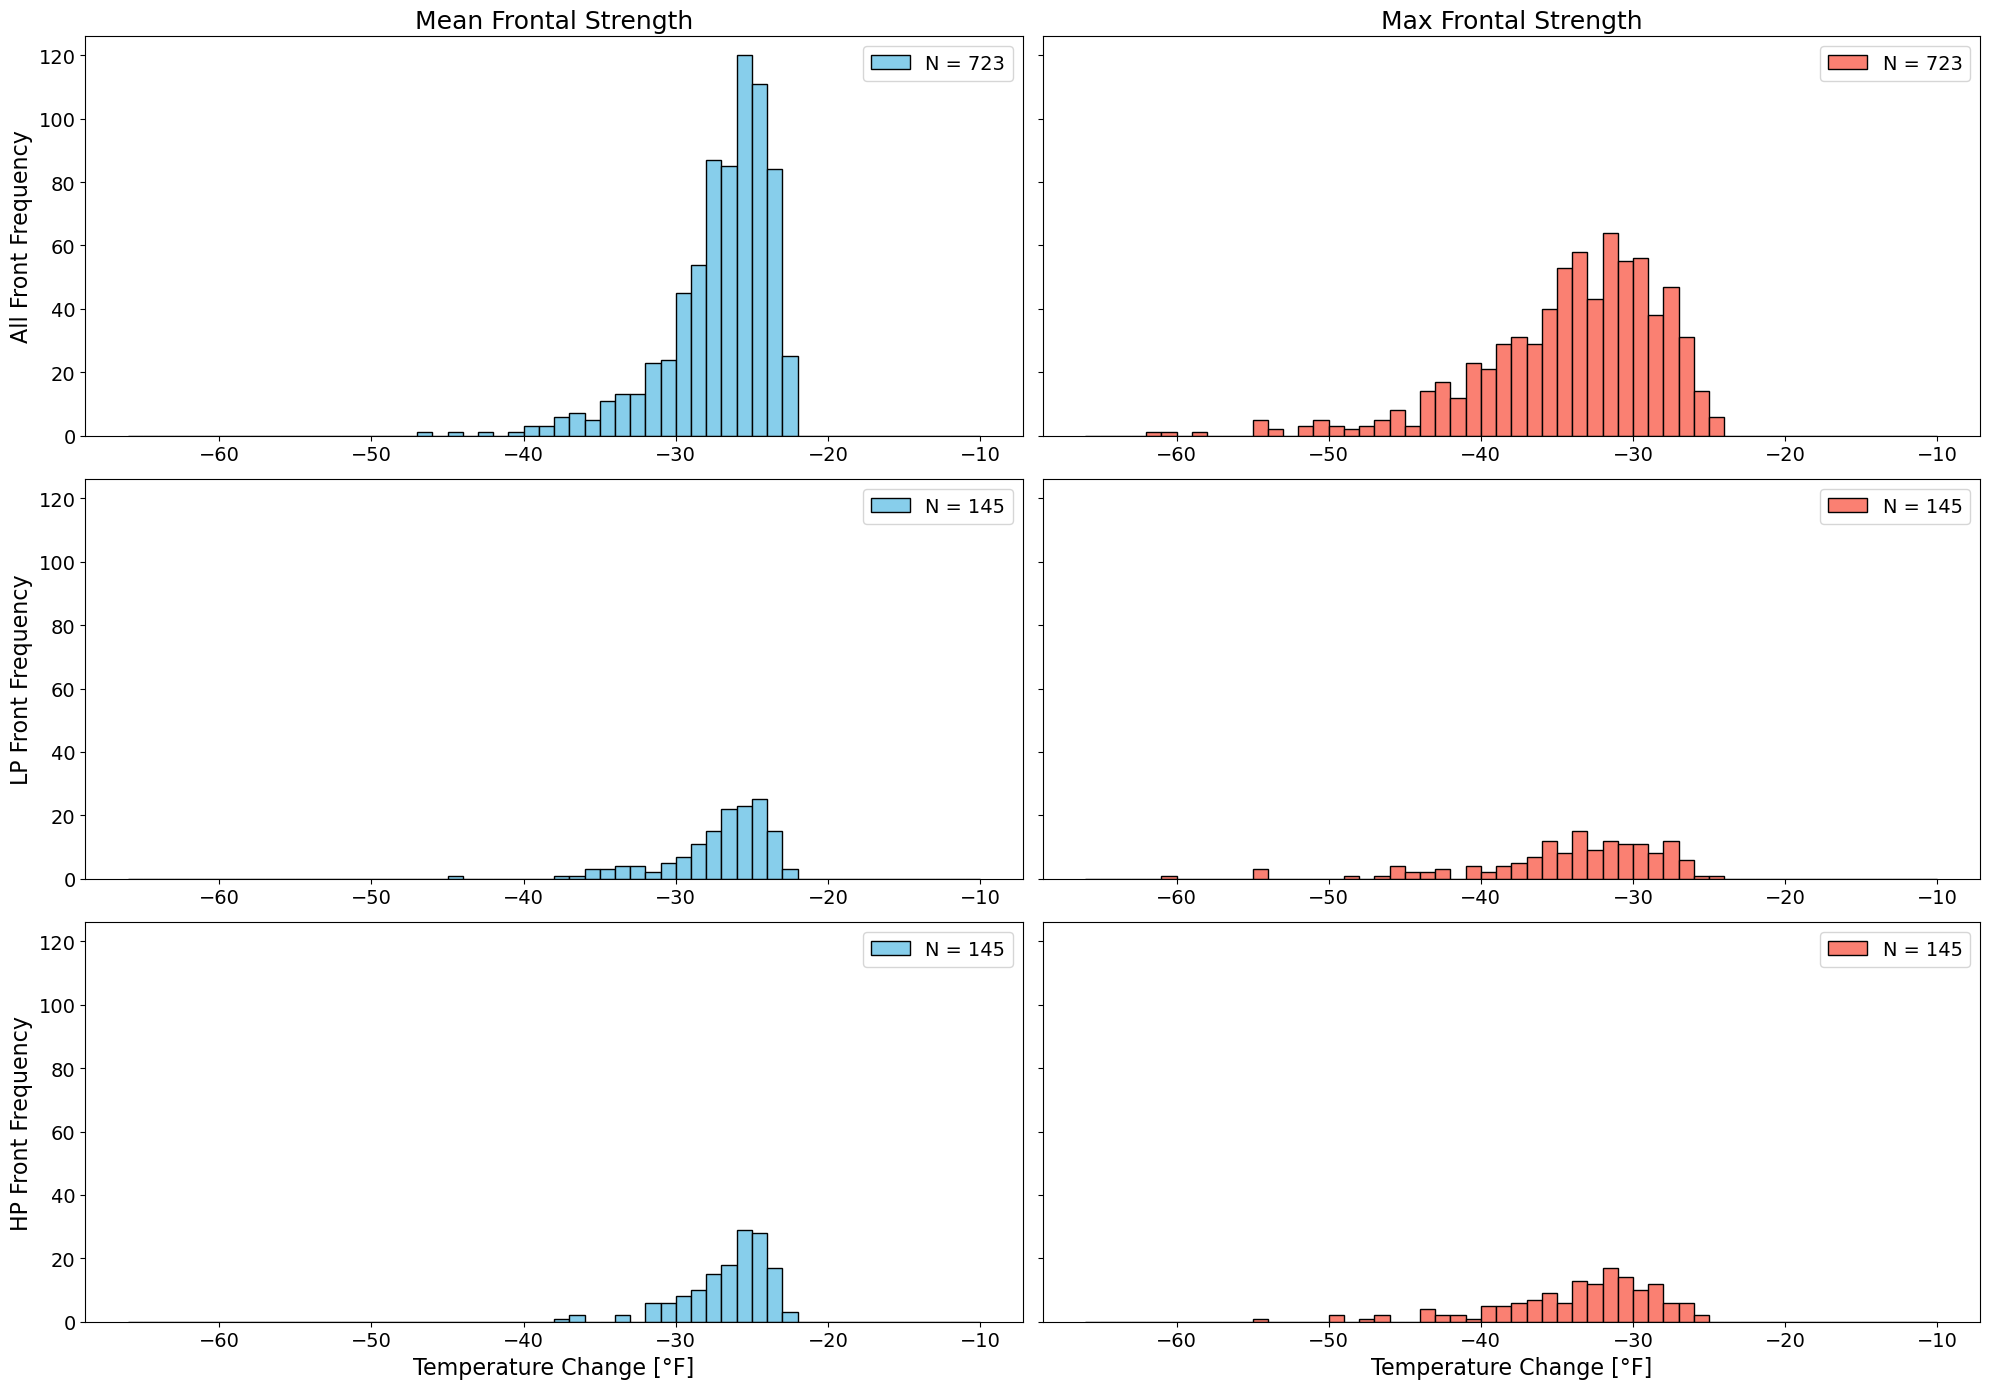

In [22]:
###Plot some statistics of Frontal Strength###

#Compute the average and maximum T drop per front#
mean_strengths = (CF_df['Temp_Diffs'].where(CF_df['CF_Dataset'] == 1)).mean(dim=['latitude', 'longitude'])
max_strengths = CF_df['Temp_Diffs'].min(dim=['latitude', 'longitude'])

mean_strengths_LP = (CF_df_LP['Temp_Diffs'].where(CF_df_LP['CF_Dataset'] == 1)).mean(dim=['latitude', 'longitude'])
max_strengths_LP = CF_df_LP['Temp_Diffs'].min(dim=['latitude', 'longitude'])

mean_strengths_HP = (CF_df_HP['Temp_Diffs'].where(CF_df_HP['CF_Dataset'] == 1)).mean(dim=['latitude', 'longitude'])
max_strengths_HP = CF_df_HP['Temp_Diffs'].min(dim=['latitude', 'longitude'])

fig, axs = plt.subplots(3, 2, figsize=(20, 14), sharey=True)

#Calculate sample sizes#
n_mean = mean_strengths.size
n_max = max_strengths.size

n_mean_LP = mean_strengths_LP.size
n_max_LP = max_strengths_LP.size

n_mean_HP = mean_strengths_HP.size
n_max_HP = max_strengths_HP.size

##All Fronts##

#Average frontal strength#
axs[0,0].hist(mean_strengths.values, bins=np.arange(-66, -9, 1), color='skyblue', edgecolor='black')  #-40, -9, 1
axs[0,0].set_title('Mean Frontal Strength', fontsize=18)
#axs[0,0].set_xlabel('Temperature Change [°F]', fontsize=16)
axs[0,0].set_ylabel('All Front Frequency', fontsize=16)
axs[0,0].tick_params(axis='both', labelsize=14)
axs[0,0].legend([f'N = {n_mean}'], loc='upper right', fontsize=14)

#Maximum frontal strength#
axs[0,1].hist(max_strengths.values, bins=np.arange(-66, -9, 1), color='salmon', edgecolor='black')   #-65, -20, 1
axs[0,1].set_title('Max Frontal Strength', fontsize=18)
#axs[0,1].set_xlabel('Temperature Change [°F]', fontsize=16)
axs[0,1].tick_params(axis='both', labelsize=14)
axs[0,1].legend([f'N = {n_max}'], loc='upper right', fontsize=14)

##LP Fronts##

#Average frontal strength#
axs[1,0].hist(mean_strengths_LP.values, bins=np.arange(-66, -9, 1), color='skyblue', edgecolor='black')  #-40, -9, 1
#axs[1,0].set_title('Mean Frontal Strength', fontsize=18)
#axs[1,0].set_xlabel('Temperature Change [°F]', fontsize=16)
axs[1,0].set_ylabel('LP Front Frequency', fontsize=16)
axs[1,0].tick_params(axis='both', labelsize=14)
axs[1,0].legend([f'N = {n_mean_LP}'], loc='upper right', fontsize=14)

#Maximum frontal strength#
axs[1,1].hist(max_strengths_LP.values, bins=np.arange(-66, -9, 1), color='salmon', edgecolor='black')   #-65, -20, 1
#axs[1,1].set_title('Max Frontal Strength', fontsize=18)
#axs[1,1].set_xlabel('Temperature Change [°F]', fontsize=16)
axs[1,1].tick_params(axis='both', labelsize=14)
axs[1,1].legend([f'N = {n_max_LP}'], loc='upper right', fontsize=14)

#HP Fronts##

#Average frontal strength#
axs[2,0].hist(mean_strengths_HP.values, bins=np.arange(-66, -9, 1), color='skyblue', edgecolor='black')  #-40, -9, 1
#axs[2,0].set_title('Mean Frontal Strength', fontsize=18)
axs[2,0].set_xlabel('Temperature Change [°F]', fontsize=16)
axs[2,0].set_ylabel('HP Front Frequency', fontsize=16)
axs[2,0].tick_params(axis='both', labelsize=14)
axs[2,0].legend([f'N = {n_mean_HP}'], loc='upper right', fontsize=14)

#Maximum frontal strength#
axs[2,1].hist(max_strengths_HP.values, bins=np.arange(-66, -9, 1), color='salmon', edgecolor='black')   #-65, -20, 1
#axs[2,1].set_title('Max Frontal Strength', fontsize=18)
axs[2,1].set_xlabel('Temperature Change [°F]', fontsize=16)
axs[2,1].tick_params(axis='both', labelsize=14)
axs[2,1].legend([f'N = {n_max_HP}'], loc='upper right', fontsize=14)

plt.tight_layout()
#plt.savefig("Mean_Max_CF", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()

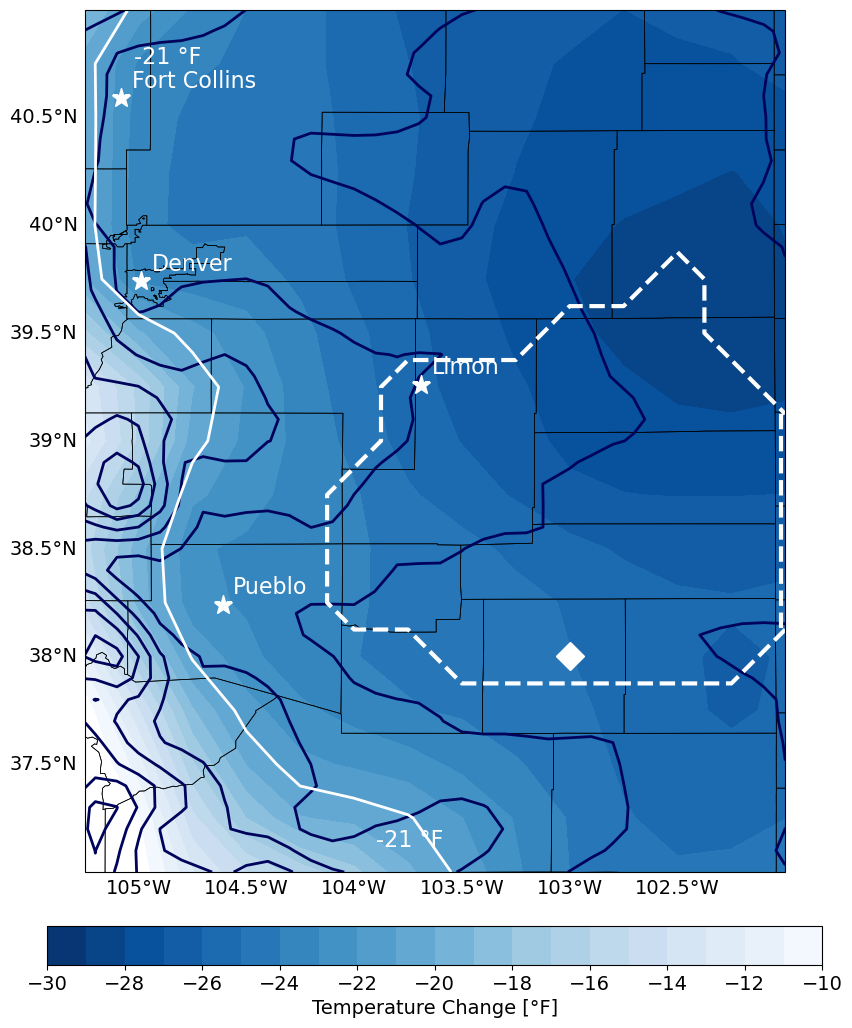

In [9]:
###Make a spatial map of the average T drops for each cell###

#Get the lons and lats#
lons = CF_df['longitude'].values
lats = CF_df['latitude'].values

#Calculate the mean temperature difference for each grid cell over time#
avg_Tdrop = CF_df['Temp_Diffs'].mean(dim='time')
CF_levels = np.arange(-30, -9, 1)

#Define the extent to tightly fit the data area#
lon_min, lon_max = np.min(lons), np.max(lons)
lat_min, lat_max = np.min(lats), np.max(lats)

#Make and configure the plot#
fig, ax = plt.subplots(1, figsize=(10, 14), subplot_kw={'projection': ccrs.PlateCarree()})
im1 = ax.contourf(lons, lats, avg_Tdrop, levels=CF_levels, cmap='Blues_r', transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(im1, ax=ax, orientation='horizontal', pad=0.05)
cbar1.set_ticks(np.arange(-30, -9, 2))
cbar1.set_label(label='Temperature Change [°F]', size=14)
cbar1.ax.tick_params(labelsize=14)

#Plot the elevation spatial data#
clevels = np.arange(800, 4000, 300)
im2 = ax.contour(df_ele_CO['longitude'], df_ele_CO['latitude'], heights, levels=clevels, colors='xkcd:dark blue', origin='lower', linewidths=2) 
#ax.clabel(im2, inline=True, fontsize=8, fmt='%1.1f')
#cbar2 = plt.colorbar(im2, ax=ax, label='Elevation [m]')

#Plot the T52 regions#
binmask_data = binmask['binary_mask_tcf'].values
im3 = ax.contour(lons, lats, binmask_data, levels=[0.5], colors='white', linestyles='dashed', linewidths=3, transform=ccrs.PlateCarree())
ax.plot(-103, 38, marker='D', markersize=14, color='white', transform=ccrs.PlateCarree()) 

#Add vertical line at the eastern edge of T52 region#
T52_east_edge = -102.02  # adjust if needed
ax.plot([T52_east_edge, T52_east_edge], [38.13, 39.14],
        color='white', linewidth=3, linestyle='dashed',
        transform=ccrs.PlateCarree(), zorder=5)

#Emphasize the 2 stdv contour T drop (-21)#
specific_level = [-21]
ax.contour(lons, lats, avg_Tdrop, levels=specific_level, colors='white', linestyles='-', linewidths=2, transform=ccrs.PlateCarree())
plt.text(-103.9, 37.12, '-21 °F', color='white', fontsize=16, transform=ccrs.PlateCarree())
plt.text(-105.02, 40.75, '-21 °F', color='white', fontsize=16, transform=ccrs.PlateCarree())
plt.tick_params(labelsize=16)
#plt.text(-102.6, 40.55, 'N=723', color='white', fontsize=16, transform=ccrs.PlateCarree())

#Plot some cities#
cities = {
    "Denver": (-104.99, 39.74),
    "Limon": (-103.69, 39.26),
    "Pueblo": (-104.61, 38.24),
    "Fort Collins": (-105.08, 40.59)
}

for city, (lon, lat) in cities.items():
    plt.plot(lon, lat, marker='*', markersize=14, markerfacecolor='white', markeredgecolor='white', transform=ccrs.PlateCarree())
    plt.text(lon + 0.05, lat + 0.05, city, color='white', fontsize=16, transform=ccrs.PlateCarree())

#Add county borders#
ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='black', linewidth=0.5)

#Set the extent to only show the area with data#
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

#Add gridlines and labels for latitude and longitude#
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='none')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}

#Configure plot#
#plt.title('Mean Temperature Change Across HP Cold Fronts', fontsize=18)
#plt.savefig("CF_DeltaT_LP_REV.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()

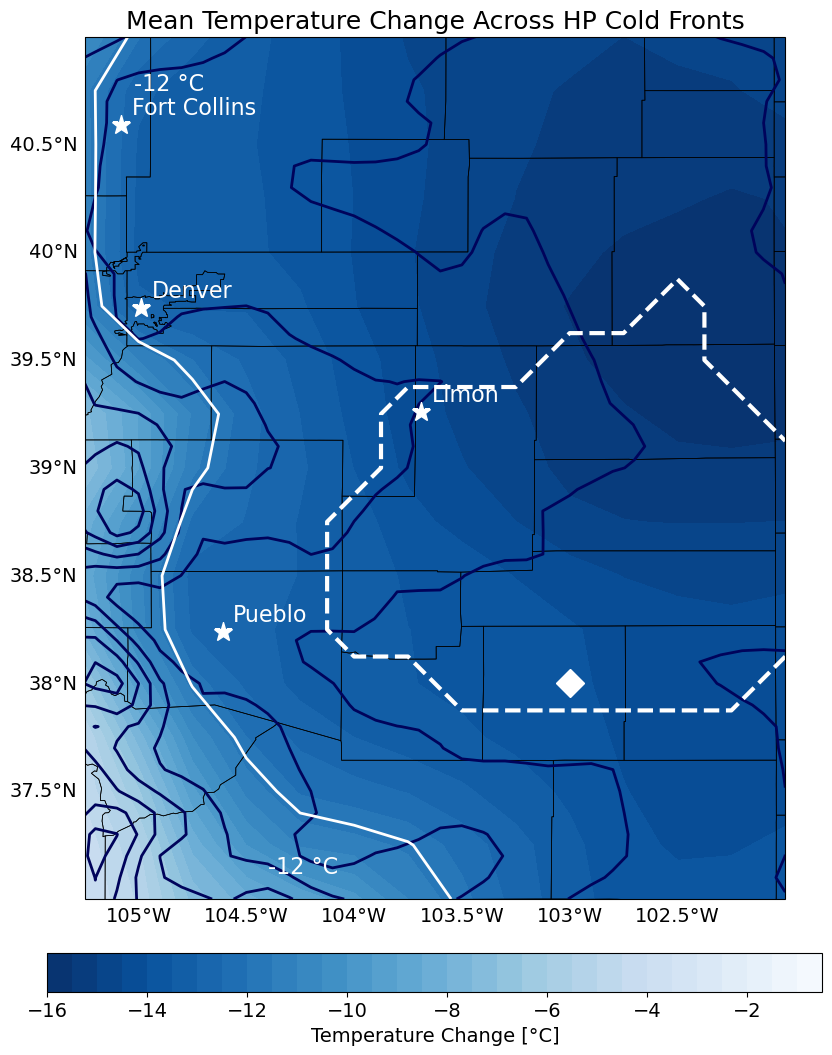

In [10]:
###Make a spatial map of the average T drops for each cell but in C now###

#Get the lons and lats#
lons = CF_df['longitude'].values
lats = CF_df['latitude'].values

#Calculate the mean temperature difference for each grid cell over time#
avg_Tdrop = CF_df['Temp_Diffs'].mean(dim='time')
avg_Tdrop_C = avg_Tdrop * 0.55555556
CF_levels = np.arange(-30, -9, 1)
CF_levels_C = np.arange(-16, 0, 0.5)

#Define the extent to tightly fit the data area#
lon_min, lon_max = np.min(lons), np.max(lons)
lat_min, lat_max = np.min(lats), np.max(lats)

#Make and configure the plot#
fig, ax = plt.subplots(1, figsize=(10, 14), subplot_kw={'projection': ccrs.PlateCarree()})
im1 = ax.contourf(lons, lats, avg_Tdrop_C, levels=CF_levels_C, cmap='Blues_r', transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(im1, ax=ax, orientation='horizontal', pad=0.05)
cbar1.set_ticks(np.arange(-16, 0, 2))
cbar1.set_label(label='Temperature Change [°C]', size=14)
cbar1.ax.tick_params(labelsize=14)

#Plot the elevation spatial data#
clevels = np.arange(800, 4000, 300)
im2 = ax.contour(df_ele_CO['longitude'], df_ele_CO['latitude'], heights, levels=clevels, colors='xkcd:dark blue', origin='lower', linewidths=2) 
#ax.clabel(im2, inline=True, fontsize=8, fmt='%1.1f')
#cbar2 = plt.colorbar(im2, ax=ax, label='Elevation [m]')

#Plot the T52 regions#
binmask_data = binmask['binary_mask_tcf'].values
im3 = ax.contour(lons, lats, binmask_data, levels=[0.5], colors='white', linestyles='dashed', linewidths=3, transform=ccrs.PlateCarree())
ax.plot(-103, 38, marker='D', markersize=14, color='white', transform=ccrs.PlateCarree()) 

#Emphasize the 2 stdv contour T drop (-21)#
specific_level = [-21]
ax.contour(lons, lats, avg_Tdrop, levels=specific_level, colors='white', linestyles='-', linewidths=2, transform=ccrs.PlateCarree())
plt.text(-104.4, 37.12, '-12 °C', color='white', fontsize=16, transform=ccrs.PlateCarree())
plt.text(-105.02, 40.75, '-12 °C', color='white', fontsize=16, transform=ccrs.PlateCarree())
plt.tick_params(labelsize=16)
#plt.text(-102.6, 40.55, 'N=723', color='white', fontsize=16, transform=ccrs.PlateCarree())

#Plot some cities#
cities = {
    "Denver": (-104.99, 39.74),
    "Limon": (-103.69, 39.26),
    "Pueblo": (-104.61, 38.24),
    "Fort Collins": (-105.08, 40.59)
}

for city, (lon, lat) in cities.items():
    plt.plot(lon, lat, marker='*', markersize=14, markerfacecolor='white', markeredgecolor='white', transform=ccrs.PlateCarree())
    plt.text(lon + 0.05, lat + 0.05, city, color='white', fontsize=16, transform=ccrs.PlateCarree())

#Add county borders#
ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='black', linewidth=0.5)

#Set the extent to only show the area with data#
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

#Add gridlines and labels for latitude and longitude#
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='none')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 14, 'color': 'black'}
gl.ylabel_style = {'size': 14, 'color': 'black'}

#Configure plot#
plt.title('Mean Temperature Change Across HP Cold Fronts', fontsize=18)
#plt.savefig("CF_DeltaT_HP_C.png", dpi=150, bbox_inches='tight', pad_inches=0.1)

plt.show()

In [11]:
##Make 2 new vars: mean and max strength of CF##

#Select Temp_Diffs where CF_Dataset is 1 
Tdrops_during_CF = CF_df['Temp_Diffs'].where(CF_df['CF_Dataset'] == 1)

#Calculate the mean T drop for CF
avg_Tdrop_CF = Tdrops_during_CF.mean(dim=['latitude', 'longitude'])

#Calculate the max T drop for CF
max_Tdrop_CF = Tdrops_during_CF.min(dim=['latitude', 'longitude'])

#Add these as 2 new data variables to the dataset
CF_df['Avg_Tdrop_cases'] = avg_Tdrop_CF
CF_df['Max_Tdrop_cases'] = max_Tdrop_CF

CF_df

<xarray.Dataset>
Dimensions:          (time: 145, latitude: 17, longitude: 14)
Coordinates:
  * longitude        (longitude) float32 -105.2 -105.0 -104.8 ... -102.2 -102.0
  * latitude         (latitude) float32 41.0 40.75 40.5 ... 37.5 37.25 37.0
  * time             (time) datetime64[ns] 1950-11-02 1950-12-27 ... 2022-11-11
Data variables:
    Daily_Max_Temps  (time, latitude, longitude) float32 ...
    Temp_Diffs       (time, latitude, longitude) float32 -19.59 ... -13.55
    CF_Dataset       (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0
    Avg_Tdrop_cases  (time) float32 -25.88 -33.05 -44.26 ... -32.67 -24.44
    Max_Tdrop_cases  (time) float32 -30.08 -46.04 -60.4 ... -35.54 -39.17 -33.54

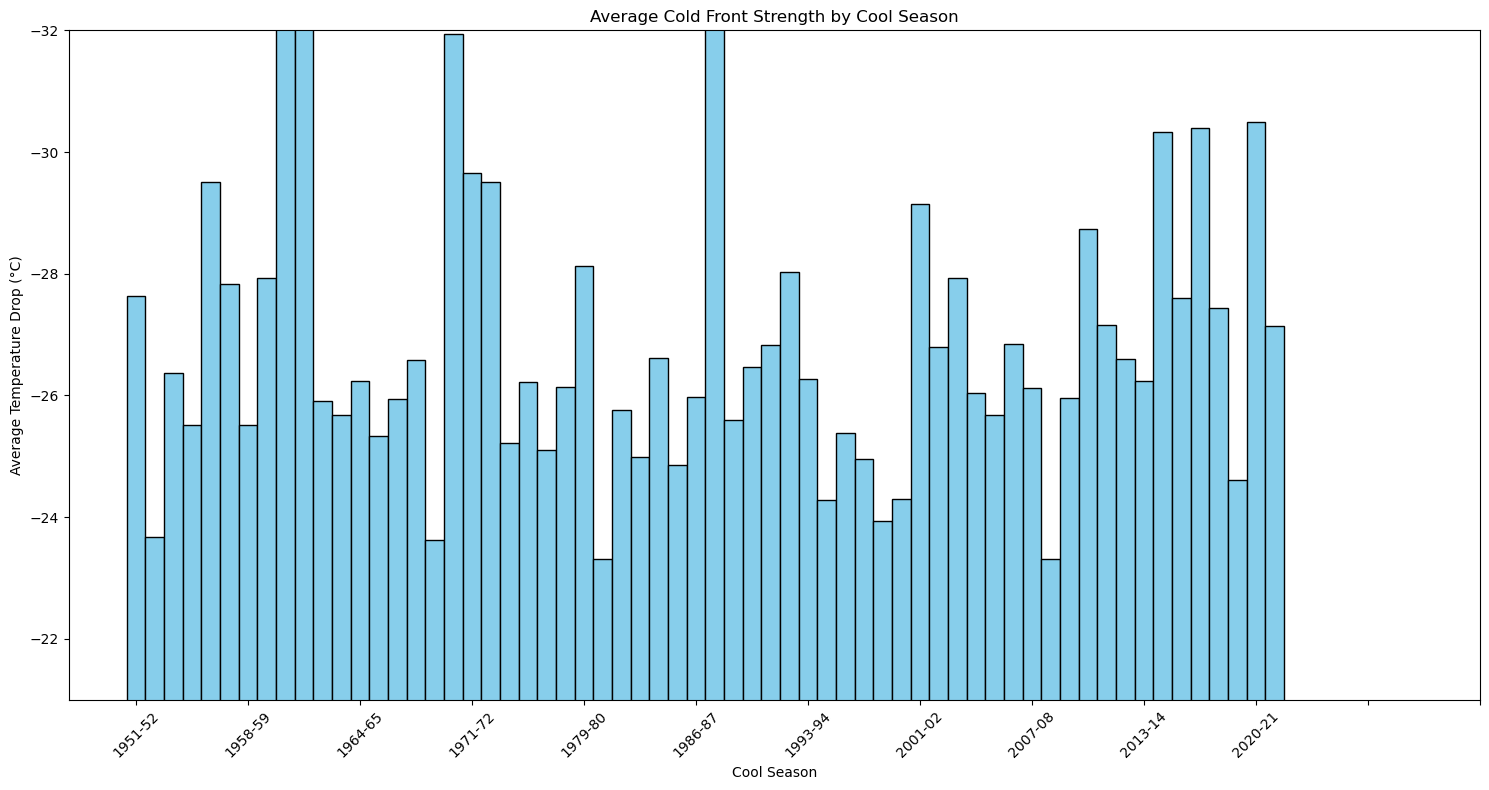

In [39]:
###Plotting the avg Front Strength by Cool Season###

#Define a function to convert dates to cool seasons (Sep-May)#
def get_cool_season(date):
    '''This function will return a string with the cool season label'''
    
    year = date.year
    
    if date.month >= 9:  #S-D will be the latter year of the cool season
        return f"{year}-{(year + 1) % 100:02d}"
    
    else:  #J-M will be the earlier year of the cool season
        return f"{year - 1}-{year % 100:02d}"

#Convert 'time' coordinate to pandas Series#
times = pd.to_datetime(CF_df['time'].values)    #change the df to get top20

#Convert 'Avg_Tdrop_cases' to pandas Series#
avg_tdrop_cases = CF_df['Avg_Tdrop_cases'].to_pandas()    #change the df to get top20

#Get the pd dataframe#
df = pd.DataFrame({
    'Cool_Season': times.to_series().apply(get_cool_season),
    'Avg_Tdrop': avg_tdrop_cases
})

#Group by cool season and calculate the mean of temperature drops, also do case#
avg_tdrop_by_season = df.groupby('Cool_Season')['Avg_Tdrop'].mean().reset_index()

#Sort the DataFrame based on Cool_Season to ensure chronological order#
avg_tdrop_by_season['Start_Year'] = avg_tdrop_by_season['Cool_Season'].apply(lambda x: int(x.split('-')[0]))
avg_tdrop_by_season.sort_values('Start_Year', inplace=True)

#Remove the first and last entry#
avg_temp_drop_per_season_filtered = avg_tdrop_by_season.iloc[1:-1]

#Plotting#
plt.figure(figsize=(15, 8))
plt.bar(avg_temp_drop_per_season_filtered['Cool_Season'], avg_temp_drop_per_season_filtered['Avg_Tdrop'], color='skyblue', edgecolor='black', width=1)

plt.xticks(rotation=90)
plt.gca().invert_yaxis()
plt.ylim([-21, -32])
plt.xticks(np.arange(0,75,6), rotation=45)
plt.xlabel('Cool Season')
plt.ylabel('Average Temperature Drop (°C)')
plt.title('Average Cold Front Strength by Cool Season')
plt.tight_layout() 

plt.show()

In [40]:
##Make an ENSO dictionary##

#ENSO seasons#
el_nino_seasons = [
    '1949-50', '1951-52','1952-53', '1953-54', '1958-59', '1963-64', '1968-69', 
    '1969-70', '1976-77', '1977-78', '1979-80', '1986-87', 
    '1994-95', '2002-03', '2004-05', '2006-07', '2009-10', 
    '1957-58', '1965-66', '1972-73', '1987-88', '1991-92',
    '1982-83', '1997-98', '2014-15', '2015-16', '2018-19'
] 

la_nina_seasons = [
    '1954-55', '1964-65', '1971-72', '1974-75', '1983-84', '1984-85', '2000-01', '2005-06', '2008-09', '2016-17', '2017-18', '2022-23',
    '1955-56', '1970-71', '1995-96', '2011-12', '2020-21', '2021-22',
    '1973-74', '1975-76', '1988-89', '1998-99', '1999-00', '2007-08', '2010-11', '2022-23'
] 

#Initialize ENSO dictionary#
enso_phases = {'El Niño': [], 'La Niña': [], 'Neutral': []}

#Loop through the rows in the avg_temp_drop_per_season_filtered DataFrame#
for index, row in avg_temp_drop_per_season_filtered.iterrows(): 
    
    season_str = row['Cool_Season']
    avg_temp_drop = row['Avg_Tdrop']
    
    #Check the cool season against the ENSO lists and append the average temperature drop#
    if season_str in el_nino_seasons:
        enso_phases['El Niño'].append(avg_temp_drop)
        
    elif season_str in la_nina_seasons:
        enso_phases['La Niña'].append(avg_temp_drop)
        
    else:
        enso_phases['Neutral'].append(avg_temp_drop)

#Convert lists back to pandas series#
el_nino_series = pd.Series(enso_phases['El Niño'], name='El Niño')
la_nina_series = pd.Series(enso_phases['La Niña'], name='La Niña')
neutral_series = pd.Series(enso_phases['Neutral'], name='Neutral')

#Combine into a df#
enso_df = pd.concat([el_nino_series, la_nina_series, neutral_series], axis=1)
enso_df

,El Niño,La Niña,Neutral
0,-27.632074,-25.516243,-27.934177
1,-23.665834,-29.505552,-33.304394
2,-26.361830,-26.229906,-32.810478
3,-27.830118,-31.943916,-25.903023
4,-25.513708,-29.656891,-25.943254
5,-25.678024,-29.502630,-26.586082
6,-25.339119,-25.225615,-26.134647
7,-23.629852,-26.615791,-23.318426
8,-26.215158,-32.578602,-25.758011
9,-25.107239,-25.378990,-24.859348


In [41]:
###Do this for indidivual cases as well###

#Initialize ENSO dictionary#
enso_phases_case = {'El Niño': [], 'La Niña': [], 'Neutral': []}

#Loop through the rows in the avg_temp_drop_per_season_filtered DataFrame#
for index, row in df.iterrows(): 
    
    coolseason_str = row['Cool_Season']
    avg_T_drop = row['Avg_Tdrop']
    
    #Check the cool season against the ENSO lists and append the average temperature drop#
    if coolseason_str in el_nino_seasons:
        enso_phases_case['El Niño'].append(avg_T_drop)
        
    elif coolseason_str in la_nina_seasons:
        enso_phases_case['La Niña'].append(avg_T_drop)
        
    else:
        enso_phases_case['Neutral'].append(avg_T_drop)

#Convert lists back to pandas series#
el_nino_series_cases = pd.Series(enso_phases_case['El Niño'], name='El Niño')
la_nina_series_cases = pd.Series(enso_phases_case['La Niña'], name='La Niña')
neutral_series_cases = pd.Series(enso_phases_case['Neutral'], name='Neutral')

#Combine into a df#
enso_df_cases = pd.concat([el_nino_series_cases, la_nina_series_cases, neutral_series_cases], axis=1)
enso_df_cases

,El Niño,La Niña,Neutral
0,-27.635874,-25.516243,-25.879118
1,-29.930979,-29.505552,-33.050762
2,-25.329374,-24.400942,-44.264843
3,-23.665834,-26.316845,-30.956715
4,-26.885502,-27.971931,-24.305208
5,-25.838158,-28.885008,-23.996103
6,-27.830118,-35.002827,-30.031538
7,-24.814926,-26.320227,-36.624660
8,-25.173128,-33.322632,-25.568974
9,-26.553070,-29.327812,-23.449606


223
262
723


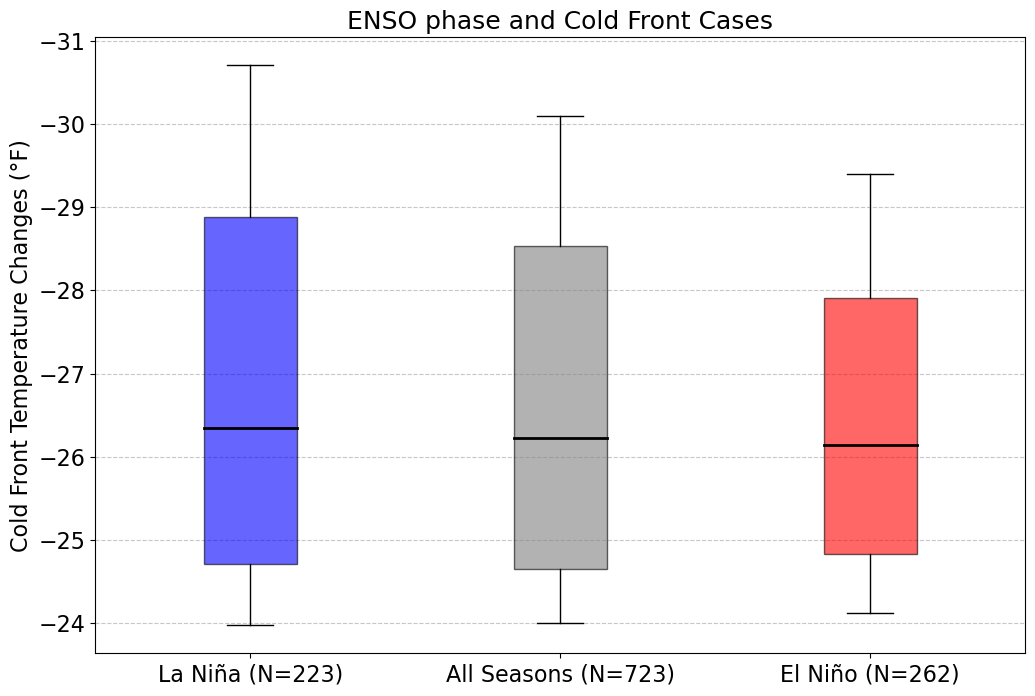

In [81]:
###Now remake ENSO boxplots but y-axis is T drops (strength) not day frequency###

#Drops Nans#
el_nino_cases = enso_df_cases['El Niño'].dropna()
la_nina_cases = enso_df_cases['La Niña'].dropna()
all_seasons_cases = pd.concat([el_nino_cases, la_nina_cases, enso_df_cases['Neutral'].dropna()])

#Print sizes#
print(len(el_nino_cases))
print(len(la_nina_cases))
print(len(all_seasons_cases))

#Prime the plotting labels#
data_to_plot_cases = [la_nina_cases, all_seasons_cases, el_nino_cases]
group_labels = ['La Niña (N=223)', 'All Seasons (N=723)', 'El Niño (N=262)']
colors = ['blue', 'grey', 'red']

#Plotting#
plt.figure(figsize=(12, 8))
bplot = plt.boxplot(data_to_plot_cases, patch_artist=True, labels=group_labels, whis=(15, 85), showfliers=False)

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

for median in bplot['medians']:
    median.set_color('black')
    median.set_linewidth(2)

#Plotting#
#plt.xlabel('Group', fontsize=14)
plt.ylabel('Cold Front Temperature Changes (°F)', fontsize=16)
plt.title('ENSO phase and Cold Front Cases', fontsize=18)
plt.gca().invert_yaxis()
plt.tick_params(labelsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.legend([bplot["boxes"][0], bplot["boxes"][1], bplot["boxes"][2]], ['All Seasons', 'El Niño', 'La Niña'], loc='upper right')

#plt.savefig("ENSO_DeltaT_All.png", dpi=150, bbox_inches='tight', pad_inches=0.1)
plt.show()
